# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler

dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


In [4]:
enhanced_data = data_loader.enhanced_incidents_df

# Imports

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

In [5]:
enhanced_data['time_call_received'] = pd.to_datetime(enhanced_data['time_call_received'])

enhanced_data['hour'] = enhanced_data['time_call_received'].dt.hour  # Hour of the day
enhanced_data['half_hour'] = enhanced_data['time_call_received'].dt.minute // 30  # Half-hour segments: 0 or 1
enhanced_data['every_20_minutes'] = enhanced_data['time_call_received'].dt.minute // 20  # 20-minute segments: 0, 1, or 2
enhanced_data['every_15_minutes'] = enhanced_data['time_call_received'].dt.minute // 15  # 15-minute segments: 0, 1, 2, or 3
enhanced_data['every_10_minutes'] = enhanced_data['time_call_received'].dt.minute // 10  # 10-minute segments: 0 to 5

hour
0     13748
1     12348
2     11050
3     10198
4      8246
5      7827
6      8325
7     10499
8     15154
9     19210
10    21853
11    22127
12    20871
13    22093
14    21487
15    19905
16    20541
17    19875
18    19840
19    20149
20    20124
21    19886
22    16692
23    15151
dtype: int64
hour  every_15_minutes
0     0                   3557
      1                   3549
      2                   3344
      3                   3298
1     0                   3244
                          ... 
22    3                   4000
23    0                   3772
      1                   3964
      2                   3737
      3                   3678
Length: 96, dtype: int64


In [6]:
def calculate_probabilities(df, time_segment):
    counts = df.groupby(time_segment).size()
    probabilities = counts / counts.sum()
    return probabilities

hourly_probabilities = calculate_probabilities(enhanced_data, 'hour')
half_hourly_probabilities = calculate_probabilities(enhanced_data, ['hour', 'half_hour'])
every_20_minutes_probabilities = calculate_probabilities(enhanced_data, ['hour', 'every_20_minutes'])
every_15_minutes_probabilities = calculate_probabilities(enhanced_data, ['hour', 'every_15_minutes'])
every_10_minutes_probabilities = calculate_probabilities(enhanced_data, ['hour', 'every_10_minutes'])

hourly_probabilities.to_csv('hourly_distribution.csv', header=['probability'])
half_hourly_probabilities.to_csv('half_hourly_distribution.csv', header=['probability'])
every_20_minutes_probabilities.to_csv('every_20_minutes_distribution.csv', header=['probability'])
every_15_minutes_probabilities.to_csv('every_15_minutes_distribution.csv', header=['probability'])
every_10_minutes_probabilities.to_csv('every_10_minutes_distribution.csv', header=['probability'])


In [9]:
def plot_probability_distribution(csv_file, title):
    df = pd.read_csv(csv_file)
    num_segments = len(df)
    
    if "hourly" in csv_file:
        x_labels = [f"{i}:00" for i in range(num_segments)]
    elif "half_hourly" in csv_file:
        x_labels = [f"{i//2}:{'00' if i % 2 == 0 else '30'}" for i in range(num_segments * 2)]
    elif "every_20_minutes" in csv_file or "every_15_minutes" in csv_file or "every_10_minutes" in csv_file:
        x_labels = df.index.astype(str)

    plt.figure(figsize=(12, 6))
    plt.bar(range(num_segments), df['probability'], tick_label=x_labels[:num_segments], width=0.4)
    
    plt.title(title)
    plt.xlabel('Time Segment')
    plt.ylabel('Probability')
    plt.xticks(rotation=90)  # Rotate for visibility
    
    plt.tight_layout()
    plt.show()

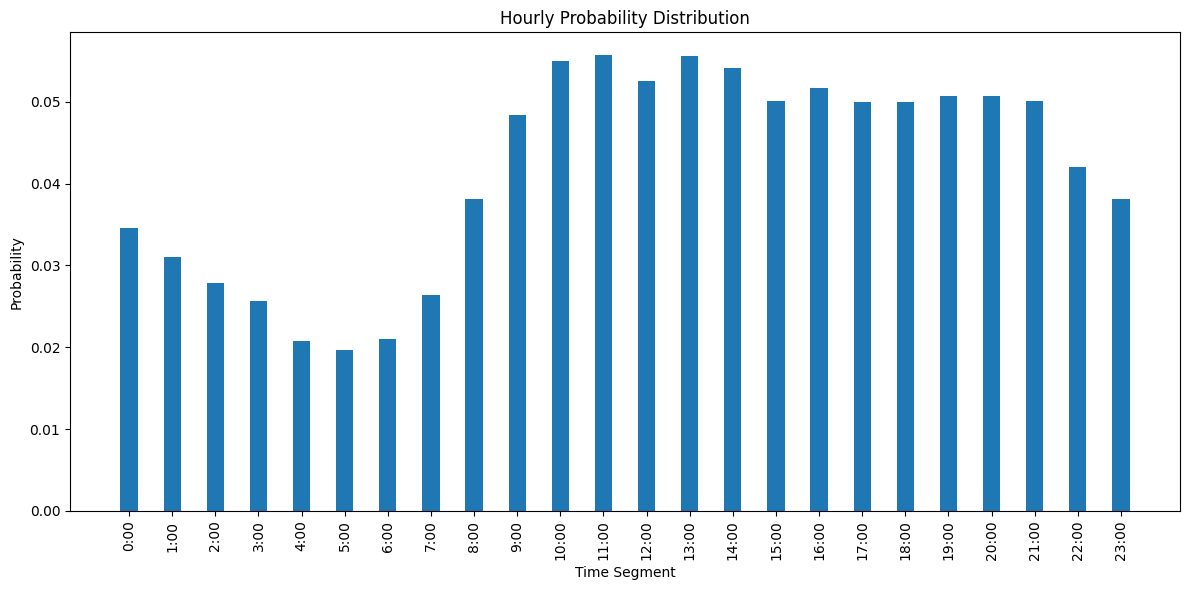

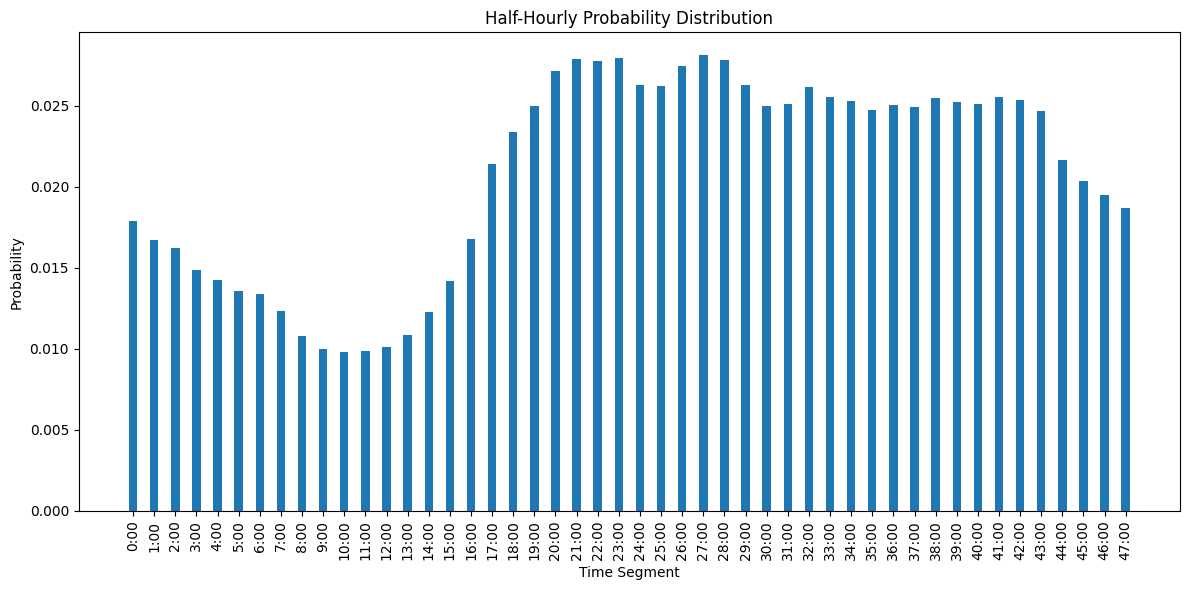

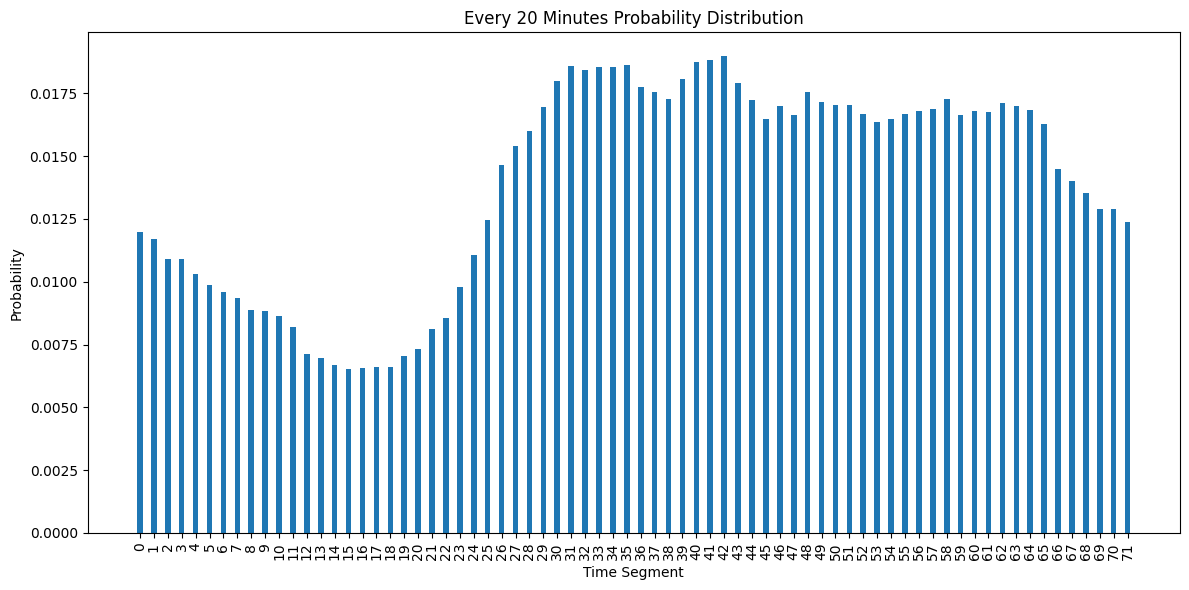

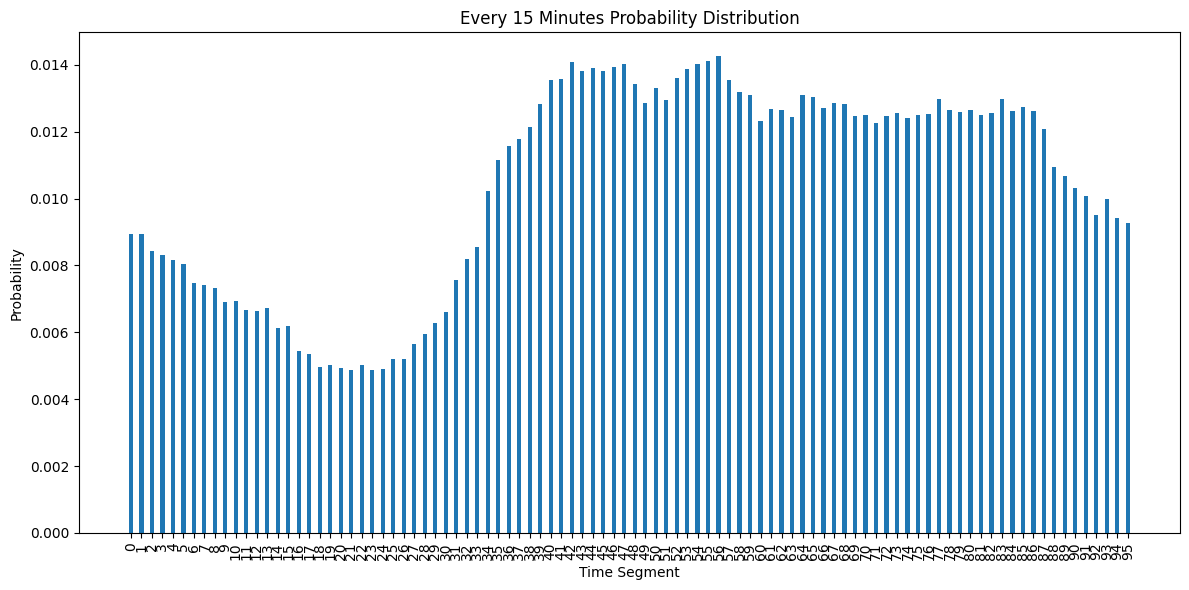

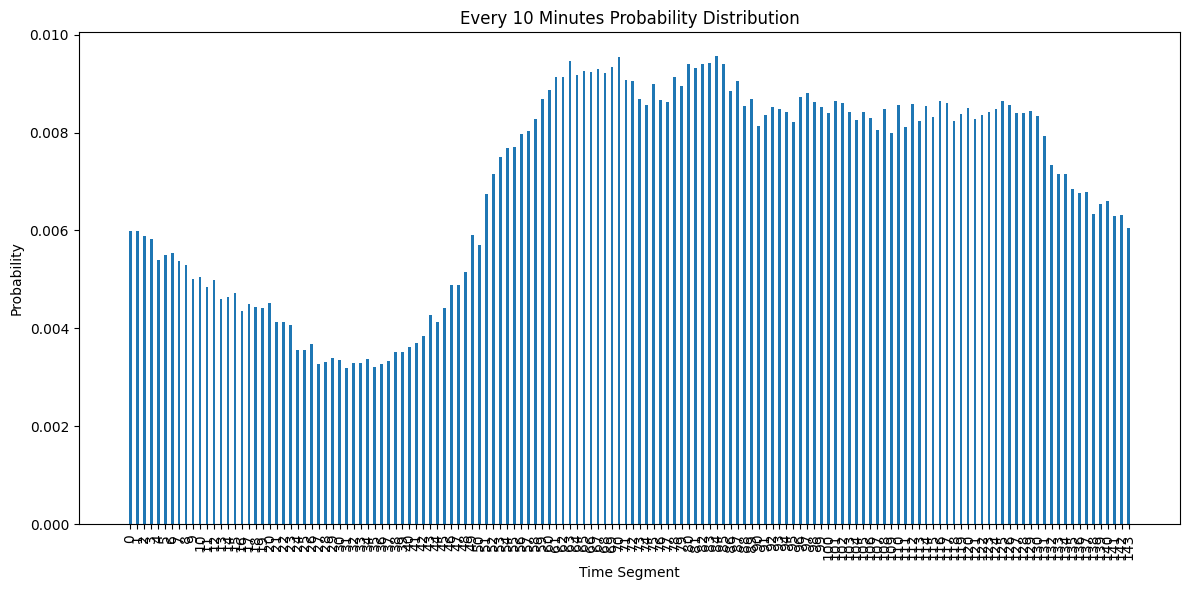

In [10]:
plot_probability_distribution('hourly_distribution.csv', 'Hourly Probability Distribution')
plot_probability_distribution('half_hourly_distribution.csv', 'Half-Hourly Probability Distribution')
plot_probability_distribution('every_20_minutes_distribution.csv', 'Every 20 Minutes Probability Distribution')
plot_probability_distribution('every_15_minutes_distribution.csv', 'Every 15 Minutes Probability Distribution')
plot_probability_distribution('every_10_minutes_distribution.csv', 'Every 10 Minutes Probability Distribution')

In [13]:
def calculate_spatial_distribution(df):
    grid_frequencies = df.groupby(['grid_row', 'grid_col']).size().reset_index(name='counts')

    total_incidents = grid_frequencies['counts'].sum()
    grid_frequencies['probability'] = grid_frequencies['counts'] / total_incidents

    grid_frequencies[['grid_row', 'grid_col', 'counts']].to_csv('grid_frequencies.csv', index=False)

    grid_frequencies[['grid_row', 'grid_col', 'probability']].to_csv('grid_probabilities.csv', index=False)


In [14]:
calculate_spatial_distribution(enhanced_data)

Spatial distribution calculated and saved to 'grid_frequencies.csv' and 'grid_probabilities.csv'.


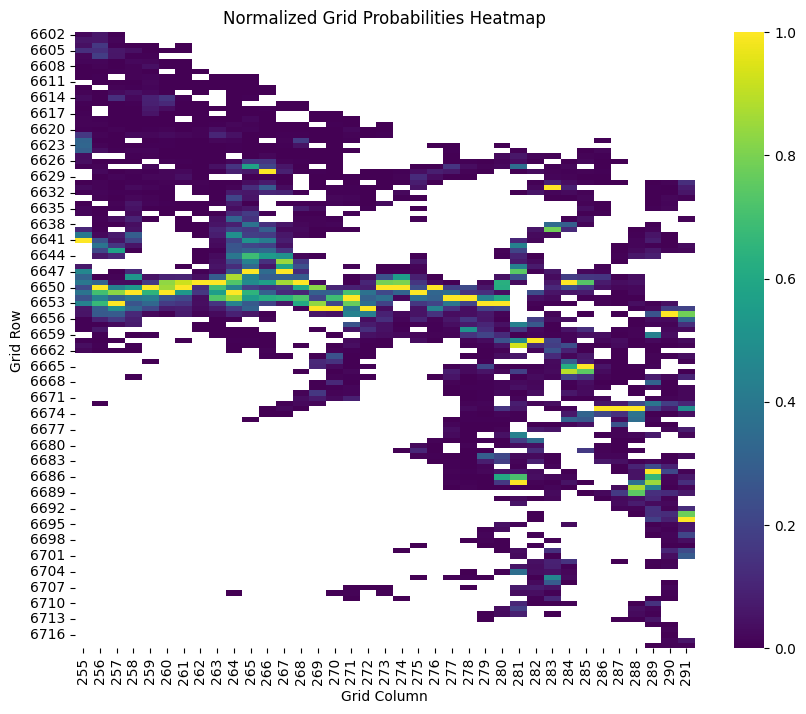

In [15]:
# Load the CSV file into a DataFrame
data = pd.read_csv('grid_probabilities.csv')

# Specify the range of rows and columns you are interested in
row_min, row_max = 6602, 6719  # Adjust these values as needed
col_min, col_max = 255, 291  # Adjust these values as needed

# Filter the data for the specified range
filtered_data = data[(data['grid_row'] >= row_min) & (data['grid_row'] <= row_max) &
                     (data['grid_col'] >= col_min) & (data['grid_col'] <= col_max)]

# Pivot the filtered DataFrame
pivot_table = filtered_data.pivot(index='grid_row', columns='grid_col', values='probability')

# Normalize the probabilities to ensure a better range of colors in the heatmap
scaler = MinMaxScaler()
pivot_table_norm = pd.DataFrame(scaler.fit_transform(pivot_table), columns=pivot_table.columns, index=pivot_table.index)

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(pivot_table_norm, cmap='viridis', annot=False)  # annot=True to display the normalized probabilities
plt.title('Normalized Grid Probabilities Heatmap')
plt.xlabel('Grid Column')
plt.ylabel('Grid Row')
plt.show()


In [18]:
def calculate_spatiotemporal_distribution(temporal_csv, spatial_csv):

    temporal_df = pd.read_csv(temporal_csv)
    spatial_df = pd.read_csv(spatial_csv)
    spatiotemporal_data = []

    for _, spatial_row in spatial_df.iterrows():
        for _, temporal_row in temporal_df.iterrows():
            spatiotemporal_probability = spatial_row['probability'] * temporal_row['probability']
            new_row = {
                'grid_row': spatial_row['grid_row'], 
                'grid_col': spatial_row['grid_col'],
                'probability': spatiotemporal_probability
            }
            if 'hour' in temporal_df.columns:
                new_row['hour'] = temporal_row['hour']
            if 'every_20_minutes' in temporal_df.columns:
                new_row['every_20_minutes'] = temporal_row['every_20_minutes']
            
            spatiotemporal_data.append(new_row)

    spatiotemporal_df = pd.DataFrame(spatiotemporal_data)

    return spatiotemporal_df

In [19]:
temporal_distribution = 'hourly_distribution.csv'
spatial_distribution = 'grid_probabilities.csv'

spatiotemporal_df = calculate_spatiotemporal_distribution(temporal_distribution, spatial_distribution)

spatiotemporal_df.to_csv('spatiotemporal_distribution.csv', index=False)


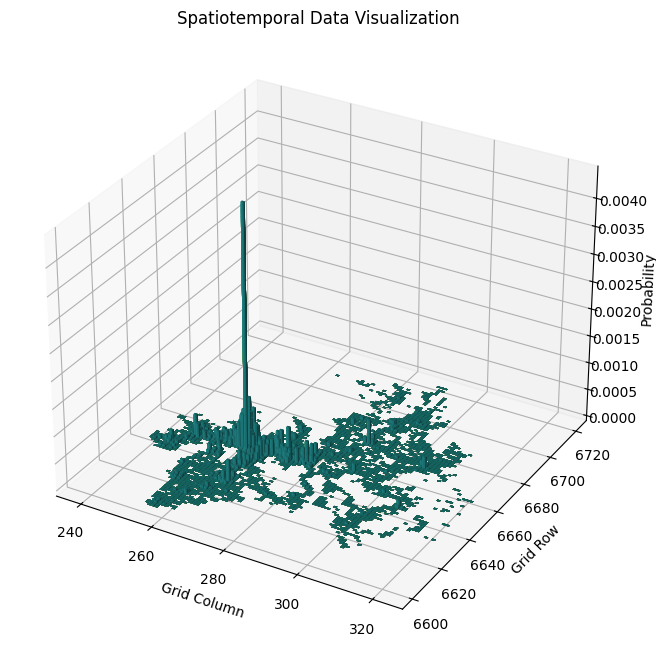

In [21]:
data = pd.read_csv('spatiotemporal_distribution.csv')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.viridis(np.linspace(0, 1, len(data['hour'].unique())))

for i, hour in enumerate(sorted(data['hour'].unique())):
    hour_data = data[data['hour'] == hour]

    x = hour_data['grid_col']
    y = hour_data['grid_row']
    z = np.zeros(len(hour_data))  # Base level for each bar
    dx = np.ones(len(hour_data)) * 0.8  # Width of the bars in x direction
    dy = np.ones(len(hour_data)) * 0.8  # Width of the bars in y direction
    dz = hour_data['probability']  # Height of the bars

    ax.bar3d(x, y, z, dx, dy, dz, color=colors[i], alpha=0.7)

ax.set_xlabel('Grid Column')
ax.set_ylabel('Grid Row')
ax.set_zlabel('Probability')
ax.set_title('Spatiotemporal Data Visualization')

plt.show()
